In [42]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils import optimal_interp_points, interp_matrix

Transverse-field Ising model

In [43]:
num_q = 3 # N # IMPORTANT 

Delta = 0.5 # g

# set H1
List_1 = []
op = "Z"
for k in range(num_q-2):
    op += "I"
op += "Z"
List_1.append(op)  
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()

H1 = SparsePauliOp(List_1, np.ones(num_q))  

# set H2
List_2 = []
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
    
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H1,H2])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian

# Print with detailed descriptions
print(f"Number of qubits (num_q): {num_q}")
print(f"Delta value: {Delta}")
print("List_1 (Pauli terms for XX interactions):")
print(List_1)
print("List_2 (Pauli terms for YY interactions):")
print(List_2)
print(H.size)
print(H)

Number of qubits (num_q): 3
Delta value: 0.5
List_1 (Pauli terms for XX interactions):
['IZZ', 'ZZI', 'ZIZ']
List_2 (Pauli terms for YY interactions):
['XII', 'IXI', 'IIX']
6
SparsePauliOp(['IZZ', 'ZZI', 'ZIZ', 'XII', 'IXI', 'IIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


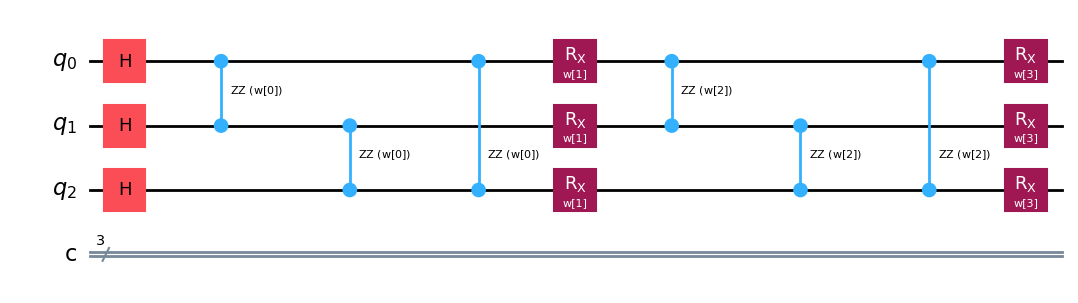

In [44]:
"""Circuit construction"""
layer = 2  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 2  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_HVA_TIFM(weights):
    circ = QuantumCircuit(num_q, num_q)

    for j in range(num_q):
        circ.h(j) 

    for i in range(layer):
        ## Odd layers
        for j in range(num_q):
            circ.rzz(weights[2 * i], j , (j + 1) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(num_q):
            circ.rx(weights[2 * i + 1], j)  ## YY gates in odd sum
            # weights  [1]

    return circ 

qc = circuit_HVA_TIFM(weights)
# print(qc)
qc.draw("mpl")
# Latex drawing
# qc.draw(output="latex")


In [45]:
simulator = AerSimulator()

def expectation_loss(WEIGHTS):
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def std(WEIGHTS):
    qc = circuit_HVA_TIFM(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))


[0.22047807 0.06889541 0.52157583 0.42383068]
2.247455295395044
1.5624693857435763
1.6094424137171908


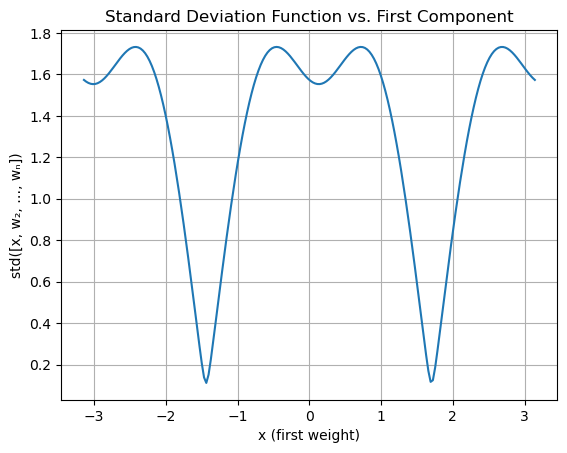

In [46]:

WEIGHTS_0 = np.random.rand(num_p)
print(WEIGHTS_0)
print(expectation_loss(WEIGHTS_0))
print(std(WEIGHTS_0))
var_fun = lambda x: std(np.concatenate(([x], WEIGHTS_0[1:])))
print(var_fun(np.random.rand()))

# Sample x in the interval [-1, 1] and compute f(x)
xs = np.linspace(-np.pi, np.pi, 200)
ys = [var_fun(x) for x in xs]

# Plot the curve
plt.plot(xs, ys)
plt.xlabel('x (first weight)')
plt.ylabel('std([x, w₂, …, wₙ])')
plt.title('Standard Deviation Function vs. First Component')
plt.grid(True)
plt.show()

In [47]:
# Interpolation matrix generation function
def interp_matrix(interp_points, Omegas):
    r = len(Omegas)
    return np.array([[1/np.sqrt(2)] + [func(Omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)] for x in interp_points])

# Mean Squared Error (MSE) function
def mse(interp_points, Omegas):
    # Create interpolation matrix
    A = interp_matrix(interp_points, Omegas)
    
    # Regularize the matrix
    regularized_matrix = A.T @ A + 1e-6 * np.eye(A.shape[1])  # Add a small regularization term to avoid singular matrix
    
    # Return the trace of the inverse of the matrix
    return np.trace(np.linalg.inv(regularized_matrix))

# Mean Squared Error (MSE) function
def mse_var(interp_points, Omegas):
    # Create interpolation matrix
    A = interp_matrix(interp_points, Omegas)
    
    d = np.array([1/var_fun(x) for x in interp_points])
    SIGMA_inv = np.diag(d)

    # Regularize the matrix
    regularized_matrix = A.T @ SIGMA_inv @ A + 1e-6 * np.eye(A.shape[1])  # Add a small regularization term to avoid singular matrix
    
    # Return the trace of the inverse of the matrix
    return np.trace(np.linalg.inv(regularized_matrix))


In [48]:
from scipy.optimize import differential_evolution

# Define the optimization function
def optimal_interp_points(Omegas, mse): 
    r = len(Omegas)

    # Define the bounds for the interpolation points
    # bounds = [(-1e6, 1e6) for _ in range(2 * r + 1)]  # This is a loose boundary range
    bounds = [(0, 2*np.pi) for _ in range(2 * r + 1)]

    # Use differential evolution for optimization
    result_mse = differential_evolution(mse, bounds, args=(Omegas,), strategy='best1bin', maxiter=1000)

    opt_mse = result_mse.fun

    # Get the optimized interpolation points
    opt_interp_points = sorted(result_mse.x)

    # Return the optimized interpolation points and the inverse of the corresponding interpolation matrix
    return opt_mse, opt_interp_points, np.linalg.inv(interp_matrix(opt_interp_points, Omegas))

opt_mse, opt_interp_points, _ = optimal_interp_points(Omegas=[2], mse=mse_var)


In [49]:

print(opt_mse, opt_interp_points)

2.3748315107330757 [1.701392537047677, 3.787228808040979, 5.898738848230712]


In [50]:
mse_var(np.random.rand(3),[2])


27253.61607412994

In [51]:
opt_interp_points[1]-opt_interp_points[0]

2.085836270993302

In [52]:
opt_interp_points[2]-opt_interp_points[1]

2.1115100401897333

In [53]:

omegas_1 = [2]
interp_nodes_1 = np.linspace(0, 2 * np.pi, 2 * len(omegas_1) + 1, endpoint=False)
inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))
print(f"Minimum MSE: {mse(interp_nodes_1, omegas_1)}")
near_opt_mse_var = mse_var(interp_nodes_1, omegas_1)
print(f"Minimum MSE: {near_opt_mse_var}")

Minimum MSE: 1.999998666667556
Minimum MSE: 2.784323283392963


In [54]:
import numpy as np

N = 1000
random_vars = [mse_var(np.random.rand(3),[2]) for _ in range(N)]

KeyboardInterrupt: 

In [ ]:
random_vars = np.array(random_vars)
rate = np.mean(random_vars > near_opt_mse_var)
print(f"经验优越率 = {rate:.3f}")

经验优越率 = 1.000


/bicmr/soft/anaconda/3-2023.03/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/bicmr/soft/anaconda/3-2023.03/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/bicmr/soft/anaconda/3-2023.03/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/bicmr/soft/anaconda/3-2023.03/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/bicmr/soft/anaconda/3-2023.03/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37319 (\N{CJK

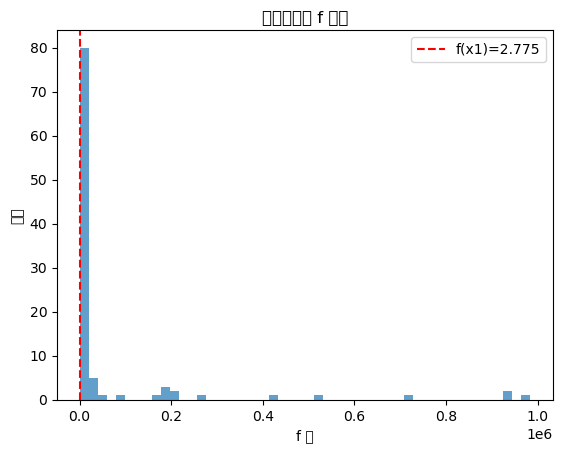

In [ ]:
import matplotlib.pyplot as plt

plt.hist(random_vars, bins=50, alpha=0.7)
plt.axvline(near_opt_mse_var, color='r', linestyle='--', label=f"f(x1)={near_opt_mse_var:.3f}")
plt.legend()
plt.xlabel("f 值")
plt.ylabel("频数")
plt.title("随机采样的 f 分布")
plt.show()


In [ ]:
mse_var(interp_nodes_1, omegas_1)-opt_mse

0.35846620914030636

In [ ]:
def check_equidistant(seq, tol=1e-8):
    """
    检查序列 seq（任意可迭代的数值列表）是否等距排列，
    如果是则返回 (True, spacing)，否则返回 (False, None)。
    
    参数：
    - seq: 可迭代的数值序列
    - tol: 判断等距的容差（默认 1e-8）
    """
    # 至少两个元素才能判断间距
    lst = list(seq)
    n = len(lst)
    if n < 2:
        return True, 0.0

    # 排序后再计算相邻差值
    s = sorted(lst)
    diffs = [s[i+1] - s[i] for i in range(n - 1)]
    d0 = diffs[0]
    
    # 检查所有 diff 是否都在容差范围内与 d0 相等
    if all(abs(d - d0) <= tol for d in diffs):
        return True, d0
    else:
        return False, None

# 示例
data = [0.9830774882923433, 3.1266245678259335, 5.196443497056742]
is_eq, spacing = check_equidistant(data, tol=1e-4)
print(is_eq)      # False
print(spacing)    # None

# 对于一个真正等距的例子：
data2 = [0.0, 2.5, 5.0, 7.5]
is_eq2, spacing2 = check_equidistant(data2)
print(is_eq2)     # True
print(spacing2)   # 2.5


False
None
True
2.5
